<a href="https://colab.research.google.com/github/maaz28/We-Health/blob/master/final_dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !git clone https://github.com/maaz28/dog_app.git

In [0]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz

Import Dog Dataset

In [0]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/content/dog_app/dogImages/train')
valid_files, valid_targets = load_dataset('/content/dog_app/dogImages/valid')
test_files, test_targets = load_dataset('/content/dog_app/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/content/dog_app/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [0]:
! test code

### Import Human Dataset

In [0]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/content/dog_app/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


## Step 1: Detect Humans

Number of faces detected: 1


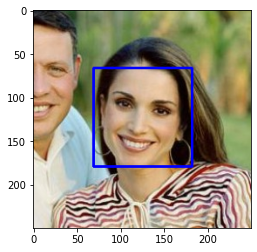

In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/dog_app/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector
  

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

(IMPLEMENTATION) Assess the Human Face Detector

In [0]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
percentage = 0

for x in range(100):
    if(face_detector(dog_files_short[x])):
        percentage +=1
        
print(percentage)

#     print(face_detector(human_files[x]))
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

12


## Step 2: Detect Dogs


In [0]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data


In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50


In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

(IMPLEMENTATION) Assess the Dog Detector

In [0]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


human_files_short = human_files[:100]
dog_files_short = train_files[:200]
# Do NOT modify the code above this line.
percentage = 0

for x in range(200):
    if(dog_detector(dog_files_short[x])):
        percentage +=1
        
print(percentage)

197


Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 137.14it/s]


### (IMPLEMENTATION) Model Architecture


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)      

### Compile the Model

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model


In [0]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='/content/dog_app/saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 15s 2ms/step - loss: 4.8841 - accuracy: 0.0079 - val_loss: 4.8706 - val_accuracy: 0.0120

Epoch 00001: val_loss improved from inf to 4.87057, saving model to /content/dog_app/saved_models/weights.best.from_scratch.hdf5
Epoch 2/5
6680/6680 [==============================] - 14s 2ms/step - loss: 4.8516 - accuracy: 0.0135 - val_loss: 4.8276 - val_accuracy: 0.0192

Epoch 00002: val_loss improved from 4.87057 to 4.82756, saving model to /content/dog_app/saved_models/weights.best.from_scratch.hdf5
Epoch 3/5
6680/6680 [==============================] - 14s 2ms/step - loss: 4.7896 - accuracy: 0.0204 - val_loss: 4.8005 - val_accuracy: 0.0192

Epoch 00003: val_loss improved from 4.82756 to 4.80052, saving model to /content/dog_app/saved_models/weights.best.from_scratch.hdf5
Epoch 4/5
6680/6680 [==============================] - 14s 2ms/step - loss: 4.7177 - accuracy: 0.0263 - val_loss: 4.7155 - 

[link text](https://)### Load the Model with the Best Validation Loss

In [0]:
model.load_weights('/content/dog_app/saved_models/weights.best.from_scratch.hdf5')

### Test the Model


In [0]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.7081%


## Step 4: Use a CNN to Classify Dog Breeds


In [0]:
bottleneck_features = np.load('/content/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

Model Architecture

In [0]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


Compile the Model

In [0]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/dog_app/saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 227us/step - loss: 7.8597 - accuracy: 0.2371 - val_loss: 3.7871 - val_accuracy: 0.4311

Epoch 00001: val_loss improved from inf to 3.78712, saving model to /content/dog_app/saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 223us/step - loss: 2.1495 - accuracy: 0.6039 - val_loss: 2.5113 - val_accuracy: 0.5832

Epoch 00002: val_loss improved from 3.78712 to 2.51131, saving model to /content/dog_app/saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 225us/step - loss: 1.2463 - accuracy: 0.7338 - val_loss: 2.4058 - val_accuracy: 0.5976

Epoch 00003: val_loss improved from 2.51131 to 2.40577, saving model to /content/dog_app/saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 223us/step - loss: 0.8227 - accuracy: 0.8109 - val_loss: 2.0511 - val_accuracy:

In [0]:
VGG16_model.load_weights('/content/dog_app/saved_models/weights.best.VGG16.hdf5')

In [0]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.0861%


Predict Dog Breed with the Model

In [0]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/content/dog_app')

from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [0]:
!wget -c https://cdn1-www.dogtime.com/assets/uploads/2011/01/file_23020_dachshund-dog-breed.jpg -O dog-14.jpg

--2020-05-09 00:03:10--  https://cdn1-www.dogtime.com/assets/uploads/2011/01/file_23020_dachshund-dog-breed.jpg
Resolving cdn1-www.dogtime.com (cdn1-www.dogtime.com)... 104.17.69.15, 104.17.70.15
Connecting to cdn1-www.dogtime.com (cdn1-www.dogtime.com)|104.17.69.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96143 (94K) [image/jpeg]
Saving to: ‘dog-14.jpg’

dog-14.jpg          100%[===================>]  93.89K  --.-KB/s    in 0.006s  

2020-05-09 00:03:10 (14.4 MB/s) - ‘dog-14.jpg’ saved [96143/96143]



In [0]:
VGG16_predict_breed('/content/dog-14.jpg')

'Images/train/025.Black_and_tan_coonhound'

In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz

--2020-05-08 23:54:51--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.248
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80602216 (77M) [application/x-www-form-urlencoded]
Saving to: ‘DogResnet50Data.npz.1’

DogResnet50Data.npz 100%[===================>]  76.87M  16.8MB/s    in 4.6s    

2020-05-08 23:54:56 (16.8 MB/s) - ‘DogResnet50Data.npz.1’ saved [80602216/80602216]



In [0]:
bottleneck_features = np.load('/content/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

(IMPLEMENTATION) Model Architecture

In [0]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [0]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model


In [0]:
checkpointer = ModelCheckpoint(filepath='/content/dog_app/saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 191us/step - loss: 1.6468 - accuracy: 0.5840 - val_loss: 0.8421 - val_accuracy: 0.7449

Epoch 00001: val_loss improved from inf to 0.84208, saving model to /content/dog_app/saved_models/weights.best.Resnet50.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 181us/step - loss: 0.4413 - accuracy: 0.8611 - val_loss: 0.6994 - val_accuracy: 0.7796

Epoch 00002: val_loss improved from 0.84208 to 0.69940, saving model to /content/dog_app/saved_models/weights.best.Resnet50.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 180us/step - loss: 0.2630 - accuracy: 0.9133 - val_loss: 0.6680 - val_accuracy: 0.7964

Epoch 00003: val_loss improved from 0.69940 to 0.66804, saving model to /content/dog_app/saved_models/weights.best.Resnet50.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 181us/step - loss: 0.1768 - accuracy: 0.9443 - val_loss: 0.6748 - val_

(IMPLEMENTATION) Load the Model with the Best Validation Loss

In [0]:
Resnet50_model.load_weights('/content/dog_app/saved_models/weights.best.Resnet50.hdf5')

In [0]:
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.5455%


### (IMPLEMENTATION) Predict Dog Breed with the Model


In [0]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/content/dog_app')

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [0]:
Resnet50_predict_breed('/content/dog_app/dogImages/valid/001.Affenpinscher/Affenpinscher_00038.jpg')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


ValueError: ignored

(IMPLEMENTATION) Load the Model with the Best Validation Loss